# Alex Hobeychi 
## The purpose of this program is to show the effectiveness of the A* start algorithm in finding the optimal path between different points.
# Necessary packages:
## - geopandas
## - pandas
## - matplotlib: pyplot, ticker
## - numpy
## - seaborn



In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

# Reading and Displaying the data

Read the shapeFile into a geopanda and convert it to a regular panda

In [2]:
crimeGeoPanda = gpd.read_file('../data/crime_dt.shp')
df = pd.DataFrame(crimeGeoPanda)

Let's take a quick look at the data frame and its columns

In [3]:
df.head()

,CATEGORIE,QUART,timestamp,geometry
0,Vols qualifiés,soir,2017-08-02 00:00:00,POINT (-73.55952 45.51703)
1,Introduction,jour,2017-08-03 00:00:00,POINT (-73.55510 45.52185)
2,Méfait,jour,2017-08-23 00:00:00,POINT (-73.58359 45.49012)
3,Vol dans / sur véhicule à moteur,jour,2018-09-05 00:00:00,POINT (-73.58794 45.52297)
4,Vol dans / sur véhicule à moteur,jour,2017-08-25 00:00:00,POINT (-73.55280 45.52430)


These are the boundaries of the area of study, as variables containing the geographical minimum and maximum

In [4]:
def calcuateNumberOfBins(min, max, size):
    return int(abs( (max - min) // size))

In [5]:
def calcuateNumberOfBinsI():
    gridSize = input('Enter the grid size')
    return int(abs( (max - min) // gridSize))

In [6]:
xmin, xmax = -73.55, -73.59
ymin, ymax = 45.49, 45.53
numberOfBins = calcuateNumberOfBins(xmax,xmin, 0.002) # This is the number of groups/blocks on each axis
xwidth = (xmax - xmin)/numberOfBins
ywidth = (ymax - ymin)/numberOfBins

In [7]:
def getX_Value(obj):
    return obj.x
#     return obj[0]
def getY_Value(obj):
    return obj.y
#     return obj[1]
df['X_VALUE'] = df['geometry'].apply(getX_Value)
df['Y_VALUE'] = df['geometry'].apply(getY_Value)    

Now, we have to convert the geometry Column to more usable features, seperate x,y and then well put them into a tuple to make the rest easier



In [8]:
def getXGroup(value):
    return (value - xmin) // xwidth
def getYGroup(value):
    return (value - ymin) // ywidth

df['X GROUP'] = df['X_VALUE'].apply(getXGroup)
df['Y GROUP'] = df['Y_VALUE'].apply(getYGroup)
df['X-Y GROUP'] = (df['X GROUP'].astype(str) + "," + df['Y GROUP'].astype(str))
df.head()

,CATEGORIE,QUART,timestamp,geometry,X_VALUE,Y_VALUE,X GROUP,Y GROUP,X-Y GROUP
0,Vols qualifiés,soir,2017-08-02 00:00:00,POINT (-73.55952 45.51703),-73.559522,45.517031,4.0,13.0,"4.0,13.0"
1,Introduction,jour,2017-08-03 00:00:00,POINT (-73.55510 45.52185),-73.555100,45.521848,2.0,15.0,"2.0,15.0"
2,Méfait,jour,2017-08-23 00:00:00,POINT (-73.58359 45.49012),-73.583593,45.490120,16.0,0.0,"16.0,0.0"
3,Vol dans / sur véhicule à moteur,jour,2018-09-05 00:00:00,POINT (-73.58794 45.52297),-73.587945,45.522974,18.0,16.0,"18.0,16.0"
4,Vol dans / sur véhicule à moteur,jour,2017-08-25 00:00:00,POINT (-73.55280 45.52430),-73.552803,45.524296,1.0,17.0,"1.0,17.0"


Now we will create a list of these X-Y groups so that we can use their indexes later to store the total amount of occurences in a 2d array

In [9]:
def convertToList(str):
    x, y = str.split(',')
    x  = float(x)
    y  = float(y)
    return (int(x),int(y))

listOfOccurences = list(df['X-Y GROUP'].apply(convertToList))
arrayOfOccurences = np.zeros((numberOfBins,numberOfBins))

for element in listOfOccurences:
    x, y = element
    arrayOfOccurences[(numberOfBins - 1) - y,(numberOfBins - 1) - x] += 1

## Now that we have all the data stored in a numpy Array, we can calculate the mean, standard deviation of the total

In [10]:
mean = np.mean(arrayOfOccurences.flatten())
print('The mean of the crimes per area for ' + str(numberOfBins) + 'x'+ str(numberOfBins)  + ' areas is ' + str(mean))
std = np.std(arrayOfOccurences.flatten())
print('The standard deviation of the crimes per area for ' + str(numberOfBins) + 'x'+ str(numberOfBins)  + ' areas is ' + str(std))

The mean of the crimes per area for 20x20 areas is 47.525
The standard deviation of the crimes per area for 20x20 areas is 49.04176154054828


Now, the dataframe and the 2d Array are set up lets visualize the dataframe

We'll clean up the axis 

In [11]:
xs = np.linspace(xmin,xmax,numberOfBins)
ys = np.linspace(ymax, ymin, numberOfBins)
x_AXIS = []
y_AXIS = []
for x, y in zip(xs,ys):
    x_AXIS.append('{:.3f}'.format(x))
    y_AXIS.append('{:.3f}'.format(y))

In [12]:
data2 = pd.DataFrame(data=arrayOfOccurences, index = y_AXIS, columns= x_AXIS )

Text(0.5, 1, 'Total Number Of Crimes per Area')

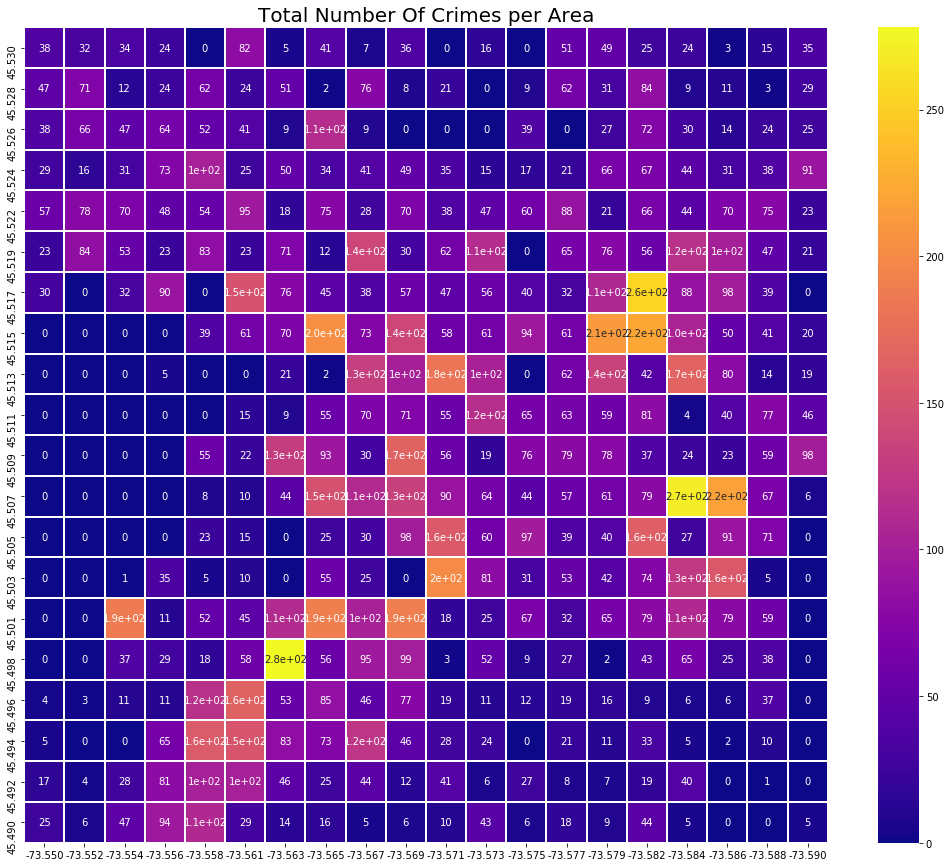

In [13]:
fig, ax = plt.subplots(1, figsize=(18, 15))
sns.heatmap(data=data2, cmap ='plasma', linewidth=1, cbar= True, annot= True)
ax.set_title('Total Number Of Crimes per Area', fontsize= 20)

### Above is the Graph of the total area, later I will use another method to make it easier to plot the line as a heatmap won't allow to draw a line.

## Set up dataFrames with all the threshold information

In [14]:
threshold50 = np.median(arrayOfOccurences.flatten())
threshold75 = np.percentile(arrayOfOccurences.flatten(),75)
threshold90 = np.percentile(arrayOfOccurences.flatten(),90)

In [15]:
def thresholdTransformation50(num):
    if num < threshold50:
        return 0
    return num
    
def thresholdTransformation75(num):
    if num < threshold75:
        return 0
    return num

def thresholdTransformation90(num):
    if num < threshold90:
        return 0
    return num

def simpleThresholdTransformation(num, threshold):
    if num < threshold:
        return 0
    else:
        return num

In [16]:
array50 = np.array(arrayOfOccurences)
array75 = np.array(arrayOfOccurences)
array90 = np.array(arrayOfOccurences)

x, y = arrayOfOccurences.shape

for i in range(x):
    for j in range(y):
        array50[i][j] = thresholdTransformation50(array50[i][j])
        array75[i][j] = thresholdTransformation75(array75[i][j])
        array90[i][j] = thresholdTransformation90(array90[i][j])

print('For the matrix with crime with threshold 50, the std is {} and the mean is {}'.format\
      (np.std(array50),np.mean(array50)))
print('For the matrix with crime with threshold 75, the std is {} and the mean is {}'.format\
      (np.std(array75),np.mean(array75)))
print('For the matrix with crime with threshold 90, the std is {} and the mean is {}'.format\
      (np.std(array90),np.mean(array90)))

For the matrix with crime with threshold 50, the std is 52.93372926358014 and the mean is 41.5175
For the matrix with crime with threshold 75, the std is 54.99333908529287 and the mean is 29.0125
For the matrix with crime with threshold 90, the std is 49.9483877993074 and the mean is 15.9675


### Standardize the matrices 1 = Crime, 0 = Safe

In [17]:
array50 = (array50 != 0)
array75 = (array75 != 0)
array90 = (array90 != 0)
df50 = pd.DataFrame(data=array50, index = y_AXIS, columns= x_AXIS )
df75 = pd.DataFrame(data=array75, index = y_AXIS, columns= x_AXIS )
df90 = pd.DataFrame(data=array90, index = y_AXIS, columns= x_AXIS )

### Lets plot the three new matrices

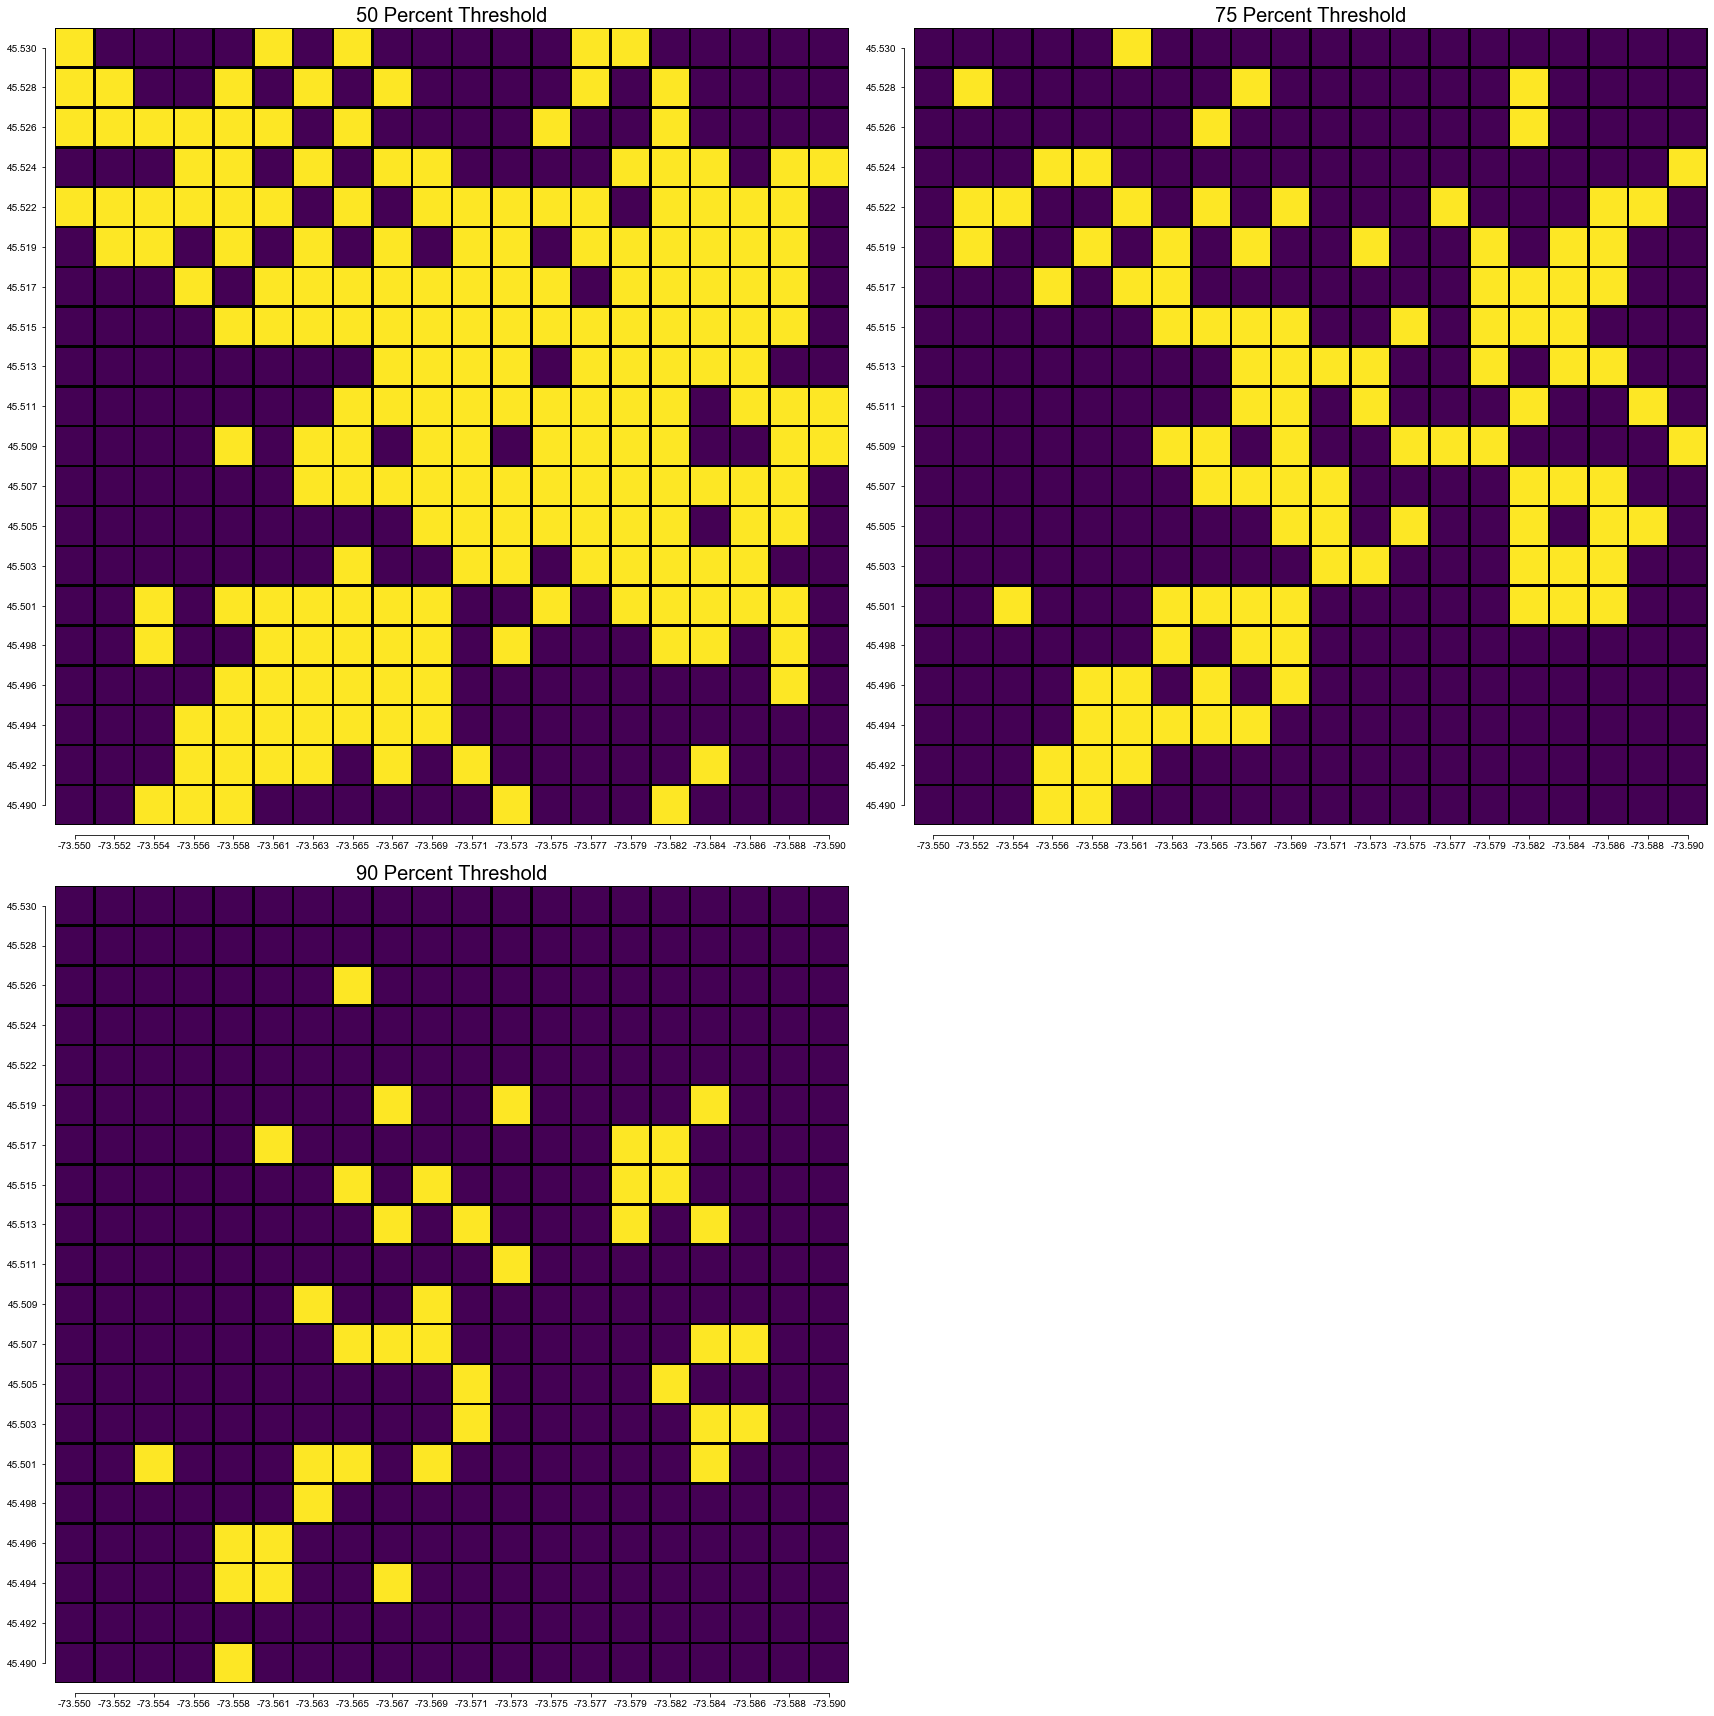

In [18]:
fig = plt.figure(figsize=(24, 24))
ax1 = fig.add_subplot(221)
ax1.set_title('50 Percent Threshold', fontsize=20)
ax2 = fig.add_subplot(222)
ax2.set_title('75 Percent Threshold', fontsize=20)
ax3 = fig.add_subplot(223)
ax3.set_title('90 Percent Threshold', fontsize=20)
sns.heatmap(data=df50, cmap ='viridis', linewidth=1.5, cbar= False, annot= False, ax = ax1, linecolor='black')
sns.heatmap(data=df75, cmap ='viridis', linewidth=1.5, cbar= False, annot= False, ax = ax2, linecolor='black')
sns.heatmap(data=df90, cmap ='viridis', linewidth=1.5, cbar= False, annot= False, ax = ax3, linecolor='black')
sns.despine(offset=10, trim=True);
sns.set(style="whitegrid")
plt.tight_layout()

# PathFinding 

## Let us graph a raw matlplot that will allow us to easily graph the path line

First we have to flip the arrays that hold the threshold information to make the plots fit the way we want them to.

In [19]:
array50Flip = np.flipud(array50)
array75Flip = np.flipud(array75)
array90Flip = np.flipud(array90)

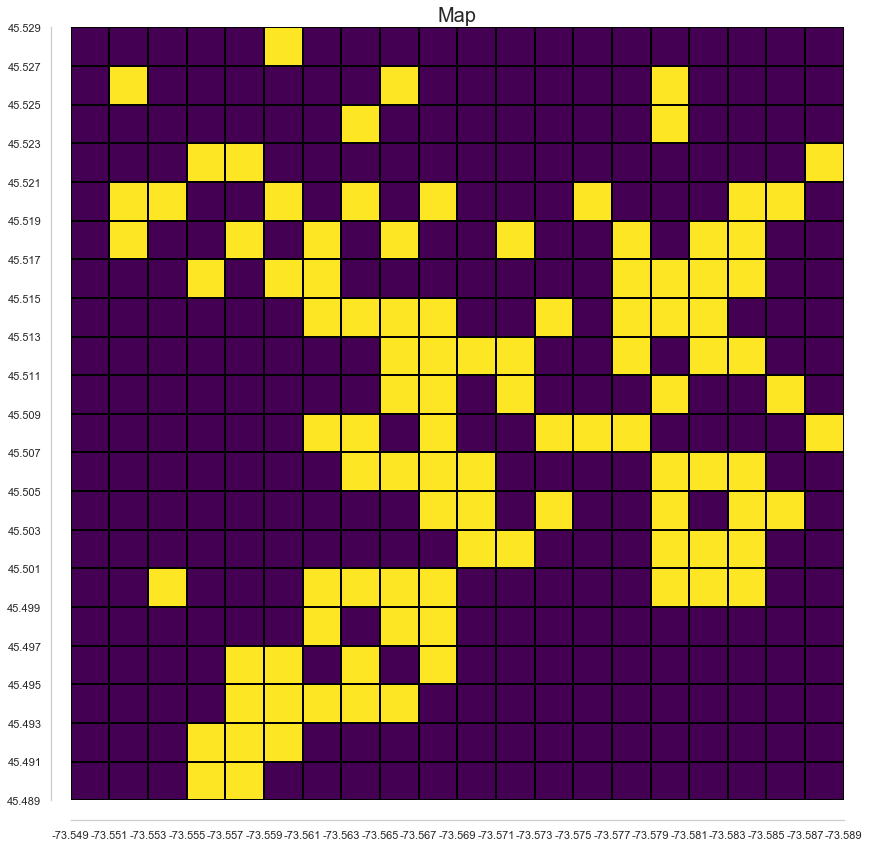

In [20]:
def plotGrid(array):

    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(array, cmap='viridis')
    
    plt.xlim([0,numberOfBins-1])
    plt.ylim([0,numberOfBins-1])
    
    ax.set_xticks(np.arange(-.5, numberOfBins, 1))
    ax.set_yticks(np.arange(-.5, numberOfBins, 1))
    
    # ax.plot(y_coords,x_coords, color = "black", linewidth=5)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: ('%g') % (ymin + (x * ywidth))))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: ('%g') % (xmin + (x * xwidth))))
    
    ax.set_title('Map', fontsize='20')
    sns.despine(offset=20, trim=True);
    sns.set(style="whitegrid")
    plt.tight_layout()
    ax.grid(linewidth=2, color= 'black')

plotGrid(array75Flip)

# A* Algorithm Implementation

First We can define all the posssible movements on the map

In [21]:
movement = [(1,0),(0,1),(-1,0),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1)]

Easily Convert longitute and latitude to fit within the array

In [22]:
def getTile(x,y):
    ceildiv = lambda a,b: -(-a // b)
    xTile = ceildiv((x-xmin),xwidth)
    yTile = ceildiv((y-ymin),ywidth)
    return xTile, yTile

### Calculate the weight of a given movement given the following conditions: 
 #### 1) movement allong a colored tile is worth 1.3. 
 #### 2) diagonal movement is worth 1.5. 
 #### 3) free movement not along a color block is worth 1.

In [23]:
def getPathWeight(start, end, array):

    x1, x2 = start[0], end[0]
    y1, y2 = start[1], end[1]
    transition = (x2 - x1, y2 - y1)

    # Up
    if(transition == (0.0, 1.0)):
        try:
            return 1.3 if (array[y1][x1] == 1 or array[y1][x1 - 1] == 1) else 1
        except:
            return  1.3 if array[y1][x1] == 1 else  1

    # Down
    elif(transition == (0.0, -1.0)):
        try:
            return  1.3 if (array[y1 - 1][x1] == 1 or array[y1 - 1][x1 - 1] == 1) else 1
        except:
            return  1.3 if (array[y1 - 1][x1] == 1) else 1

    # Right
    elif(transition == (1.0, 0)):
        try:
            return  1.3 if (array[y1][x1] == 1 or array[y1-1][x1] == 1) else 1
        except:
            return 1.3 if (array[y1][x1] == 1) else 1
            
    # Left
    elif(transition == (-1.0, 0)):
        try:
            return 1.3 if (array[y1][x1 - 1] == 1 or array[y1 - 1][x1 - 1] == 1) else 1
        except:
            return 1.3 if (array[y1][x1 - 1] == 1) else 1

    else:
        return 1.5

### We define a class that will hold all necessary information to process the computation


In [24]:
class node:

    def __init__(self, previous, location):
        self.previous = previous
        self.location = location
        self.x = location[0]
        self.y = location[1]

        self.gn = 0
        self.hn = 0
        self.fn = 0

    def __eq__(self, other):
        return self.location == other.location

    def __lt__(self, other):
        return self.fn < other.fn

    def __gt__(self, other):
        return self.gn > other.gn

    def createNewLocation(self,shift):
        return (self.location[0] + shift[0], self.location[1] + shift[1])

    def getLocation(self):
        return (self.x, self.y)

    def calculateValues(self, other, end, array):
        #actual cost of path from start to node n
        weight = getPathWeight(self.getLocation(), other.getLocation(), array)
        self.gn = other.gn + weight
        # estimate of cost to reach goal from node n 
        # Uses Manhattan Distance
        # self.hn = abs(self.x - end.x) + abs(self.y - end.y)
        # Uses Pythagorean Distance, Seems to improve performance
        self.hn = 1.5*(abs(self.x - end.x)**2 + abs(self.y - end.y)**2)**0.5
        # estimate of total cost along path through n
        self.fn = self.gn + self.hn
        
    def __str__(self):
        return (str((x,y)))

### We define all restrictions for the pathfinding algorithm

checking if the area is valid (not surrounded by blocked areas)

In [25]:
def invalidArea(array, coord):

    current = (array[coord[1]][coord[0]] == 1) 
    left = (array[coord[1]][coord[0] - 1] == 1) 
    bottom = (array[coord[1] - 1][coord[0]] == 1) 
    bottomLeft = (array[coord[1] - 1][coord[0] - 1] == 1)
    
    return current and left and bottom and bottomLeft

checking if the area selecting is within the boundaries of the board

In [26]:
def withinBoundary(location):
    x, y = location[0], location[1]
    return (x < numberOfBins and y < numberOfBins) and (x > 0 and y > 0)

checking if a movement from a given area is valid 

In [27]:
def invalidMove(coord, shift, array):

    newLocation = (coord[1] + shift[1], coord[0] + shift[0])
    if not withinBoundary(newLocation):
        return True
        
    ## (1,1) Right Up
    if shift == (1,1):
        return (array[coord[1]][coord[0]] == 1) 

    ## (-1,1) Left Up
    elif shift == (-1,1):
        return (array[coord[1]][coord[0] - 1] == 1) 

    # (-1,-1) Down Left
    elif shift == (-1,-1):
        return (array[coord[1] - 1][coord[0] - 1] == 1)

    ## (1,-1) Down Right
    elif shift == (1,-1):
        return (array[coord[1] - 1][coord[0]] == 1)

    # ## (1, 0) Right
    elif shift == (1,0):
        try:
            return (array[coord[1]][coord[0]] == 1) and (array[coord[1] - 1][coord[0]] == 1)
        except:
            return (array[coord[1]][coord[0]] == 1)
            
    # ## (-1, 0) Left 
    elif shift == (-1,0):
        try:
            return (array[coord[1]][coord[0] - 1] == 1 and array[coord[1] - 1][coord[0] - 1] == 1)
        except:
            return (array[coord[1]][coord[0] - 1] == 1)

    ## (0, 1) Up
    elif shift == (0,1):
        try:
            return (array[coord[1]][coord[0]] == 1 and array[coord[1]][coord[0] - 1] == 1)
        except:
            return (array[coord[1]][coord[0]] == 1)

    ## (0,-1) Down 
    elif shift == (0,-1):
        try:
            return (array[coord[1] - 1][coord[0]] == 1 and array[coord[1] - 1][coord[0] - 1] == 1)
        except:
            return (array[coord[1] - 1][coord[0]] == 1)
            
    return False 

### Define the bulk Of the A* Algorithm

In [28]:
def search(start, end, array):
    
    # We check wether or not the end and start are valid
    if (not (withinBoundary(start) and withinBoundary(end))) or invalidArea(array, start) or invalidArea(array,end):
        print('The input was not valid')
        return None
    
    # We define the known nodes
    start = node(None, start)
    end = node(None, end)

    # To track all the nodes
    opened, closed = [],[]

    # We start with the first
    opened.append(start)

    while(opened):
        
        current = opened[0]
        index = 0
        
        for i, test in enumerate(opened):
            if test < current:
                current = test
                index = i

        # We remove from open and add it to close
        opened.pop(index)
        closed.append(current)

        # We See if we're done
        if current == end:
            path = []
            temp = current
            while (temp):
                path.append(temp.location)
                temp = temp.previous 
            return path, current.gn

        #We explore all the possible neighbours
        neighbours = []
        for shifts in movement:
            
            newLocation = current.createNewLocation(shifts)

            # Check if the new location is valid
            if (not withinBoundary(newLocation)) or invalidMove(current.getLocation(), shifts, array):
                continue

            newNode = node(current, newLocation)

            # check that the node wasn't already visited to remove redundancies 
            if(newNode in closed):
                for x in closed:
                    if newNode == x and newNode.gn > x.gn:
                        continue
            # if(newNode in closed):
            #     continue
            else:
                neighbours.append(newNode)

        for neighbor in neighbours:
            
            # Now we check that we havent visited the new location
            # for closedNode in closed:
            #     if neighbor == closedNode:
            #         continue
            
            # We set the values of g(n), h(n) and f(n)
            neighbor.calculateValues(current,end,array)

            # neighbor is already in the open list
            for open in opened:
                if neighbor == open and neighbor > open:
                    continue

            # Add the child to the open list
            opened.append(neighbor)

### Define all the necessary plotting tools and funtions

In [29]:
from time import time

def unzipPath(path):
    x,y  = [], []
    for j in path:
        x.append(j[0] - .5)
        y.append(j[1] - .5)
    return np.array(x),np.array(y)

def plot_path_50(start, end):
    __draw(start,end,array50Flip)

def plot_path_75(start, end):
    __draw(start,end,array75Flip)

def plot_path_90(start, end):
    __draw(start,end,array90Flip)

def __draw(start, end, array):

    startTime = time()
    searchResults = search(start,end, array)

    if(searchResults == None or len(searchResults[0]) == 1 or start == end):
        print('no route exists')
        return None

    endTime = time()
    realPath = searchResults[0][::-1]

    if(len(realPath) == 0):
        return
    
    x, y = unzipPath(realPath)
    weight = searchResults[1]

    titleWithRunTime = 'Pathfinding - Process Time: {} seconds, Path Weight: {}'.format(round((endTime-startTime),3), round(weight,1))
    fig, ax = plt.subplots(figsize = (12,12))
    ax.imshow(array, cmap='viridis', zorder=0)
    plt.xlim([0,numberOfBins-1])
    plt.ylim([0,numberOfBins-1])
    ax.set_xticks(np.arange(-.5, numberOfBins, 1))
    ax.set_yticks(np.arange(-.5, numberOfBins, 1))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: ('%g') % (ymin +   (x * ywidth))))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: ('%g') % (xmin +   (x * xwidth))))
    ax.set_title(titleWithRunTime, fontsize='20')
    sns.despine(offset=20, trim=True)
    sns.set(style="whitegrid")
    plt.tight_layout()
    ax.grid(linewidth=2, color= 'black')
    ax.scatter(x[0],y[0], marker = ".", color = "white", s = 200, zorder=2)
    ax.scatter(x[-1],y[-1], marker = "X", color = "white", s = 400,zorder=2)
    ax.plot(x,y, color = "white", linewidth=3,zorder=1)
    plt.show()

### Testing the algorithm 

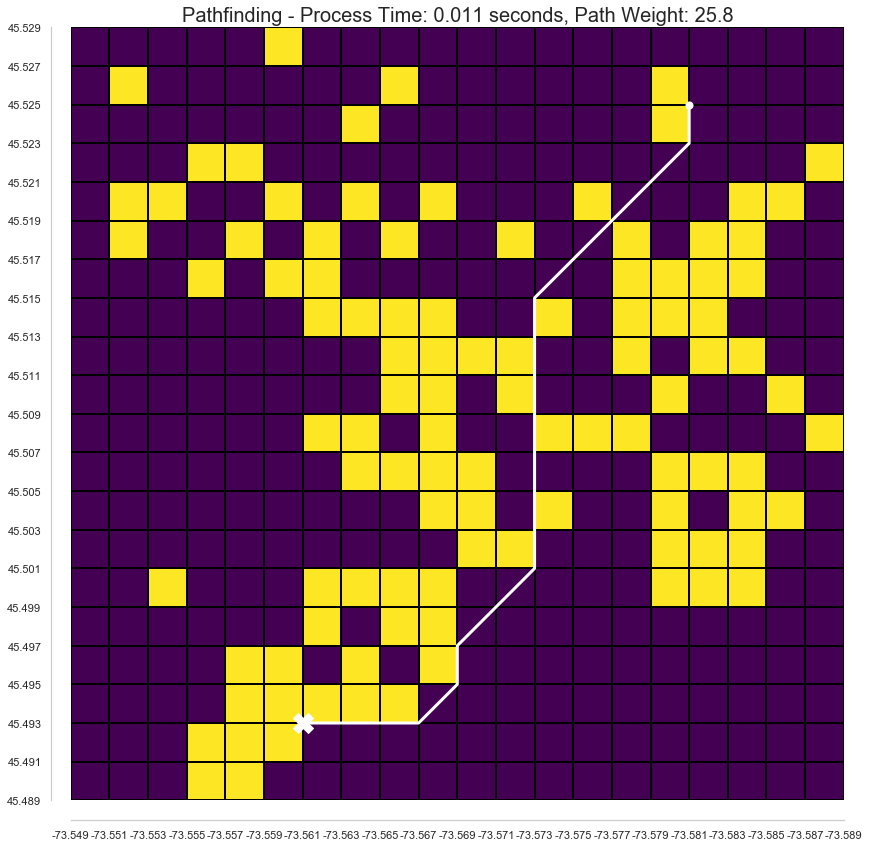

In [30]:
plot_path_75((16,18),(6,2))

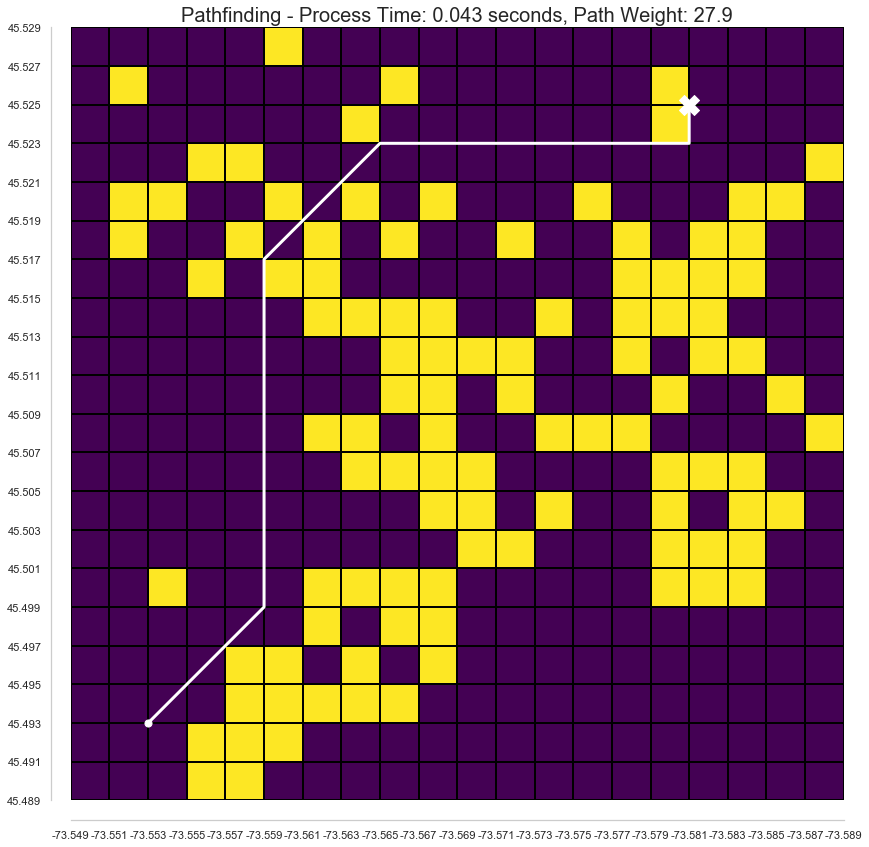

In [31]:
plot_path_75((2,2), (16,18))

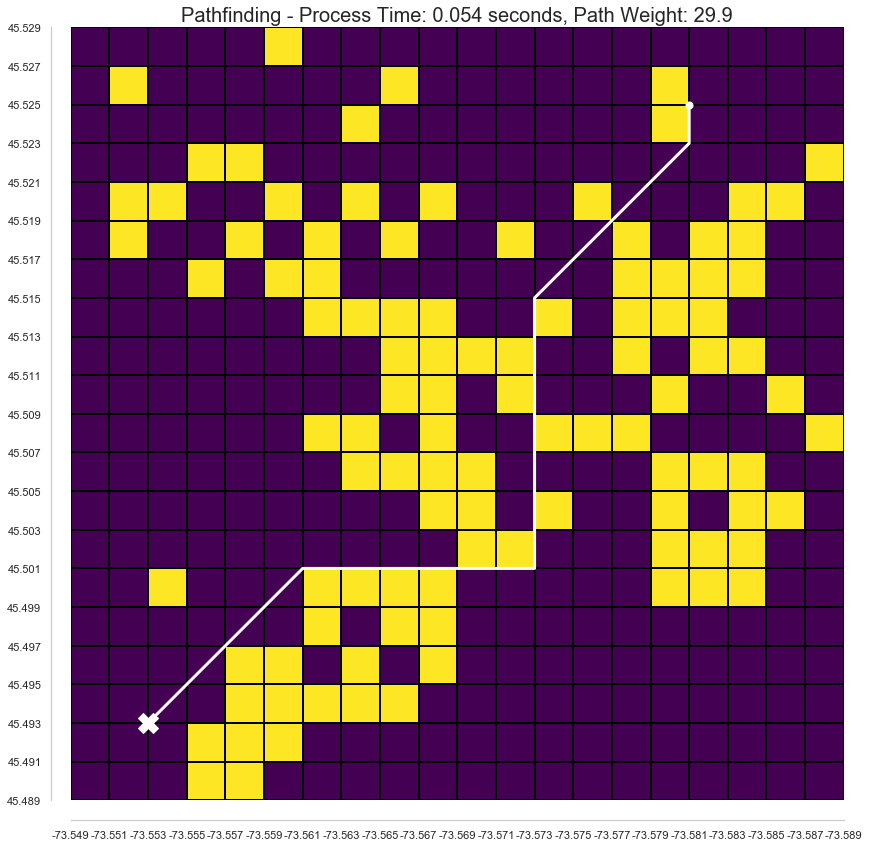

In [32]:
plot_path_75((16,18),(2,2))

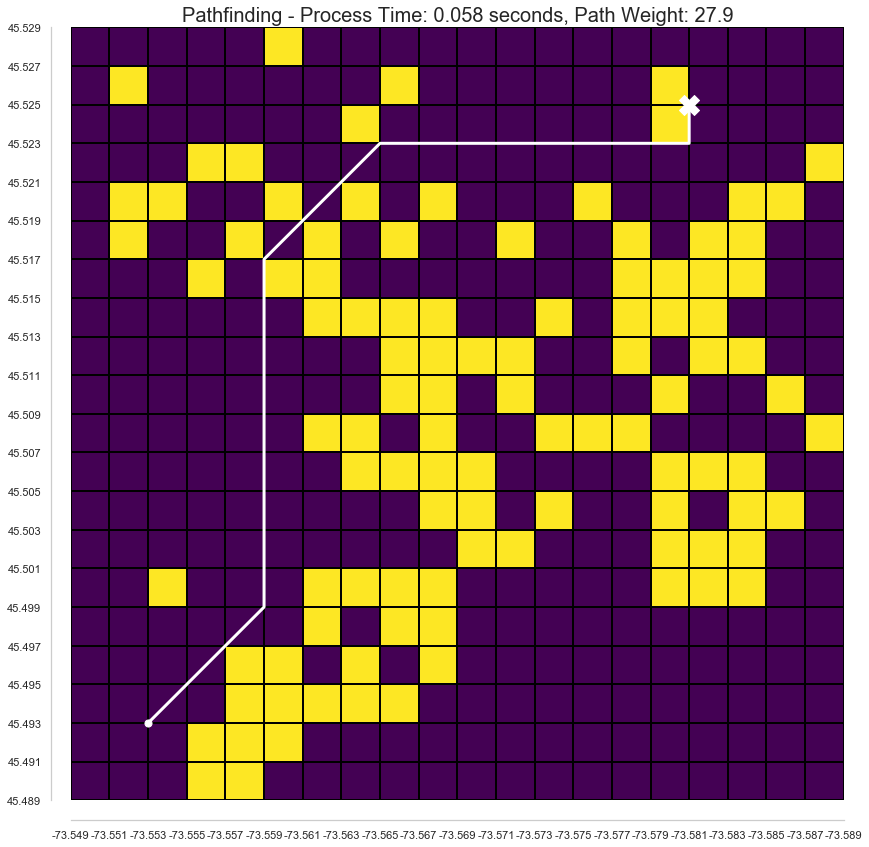

In [33]:
plot_path_75((2,2),(16,18))

In [34]:
plot_path_75((2,2),(16,13))

The input was not valid
no route exists


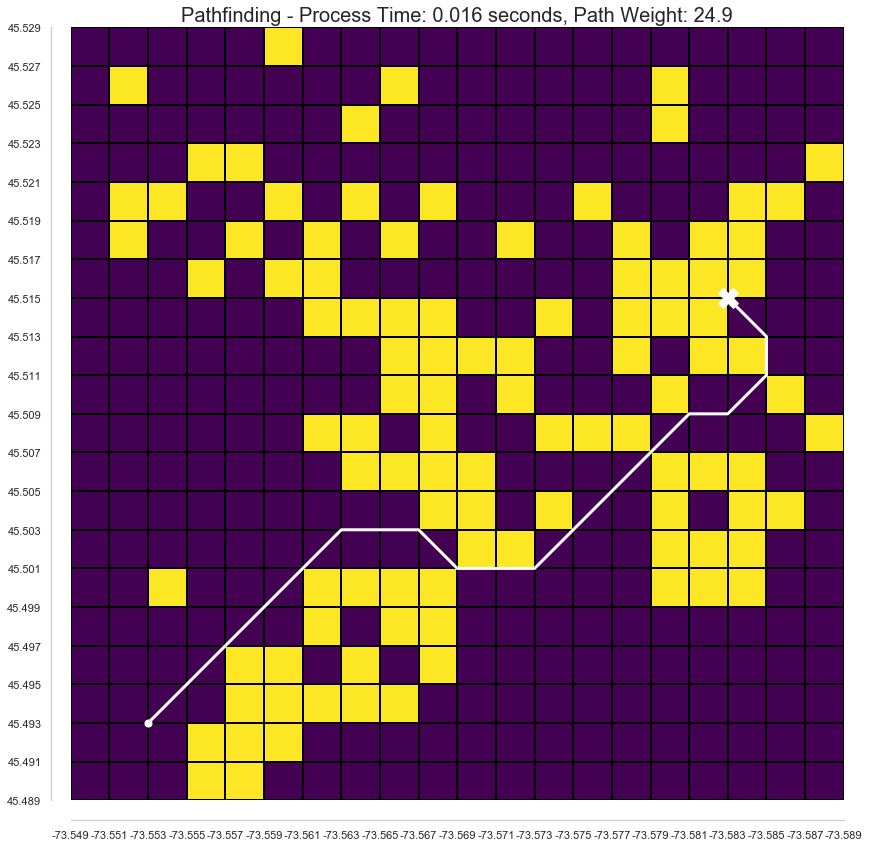

In [35]:
plot_path_75((2,2),(17,13))

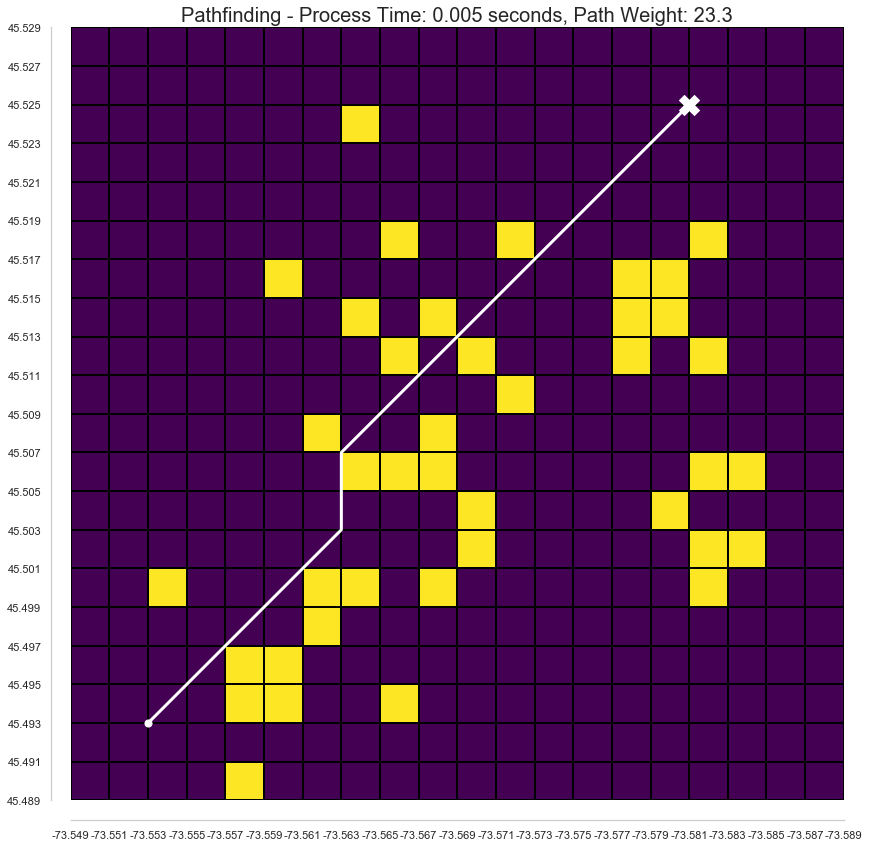

In [36]:
plot_path_90((2,2),(16,18))

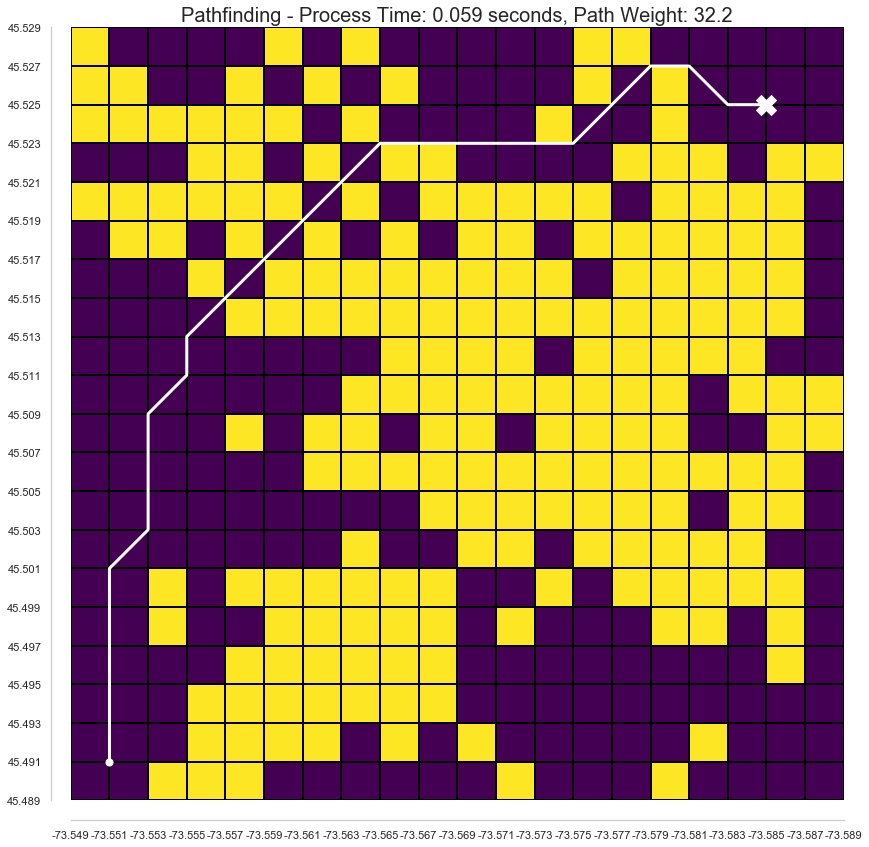

In [37]:
plot_path_50((1,1), (18,18))

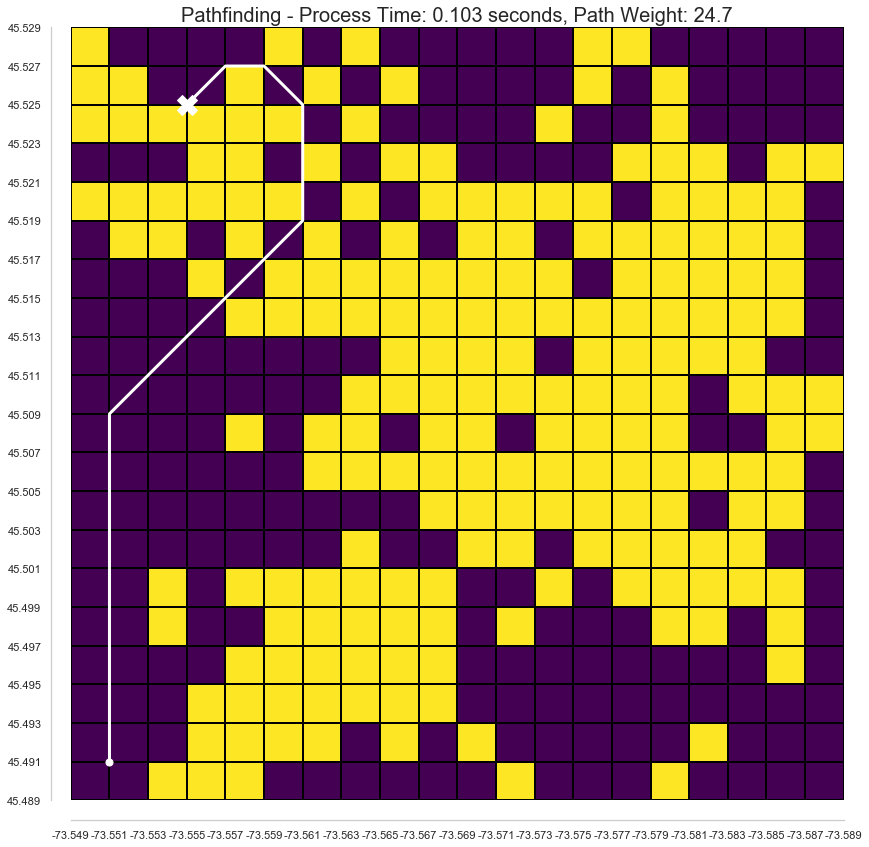

In [38]:
plot_path_50((1,1), (3,18))

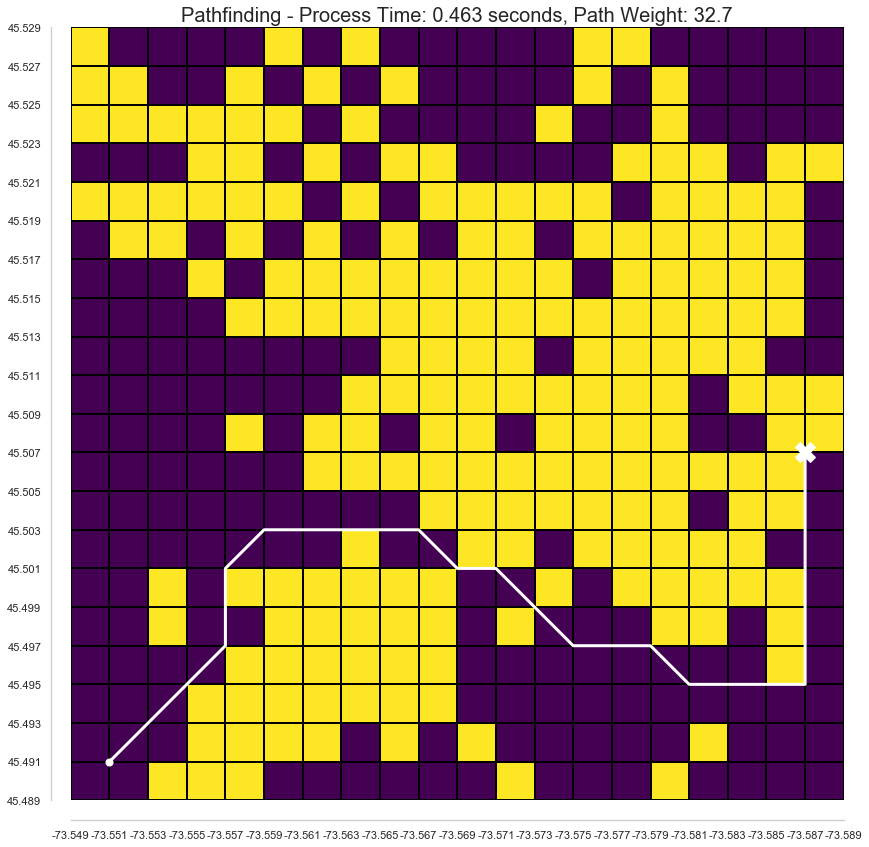

In [39]:
plot_path_50((1,1), (19,9))

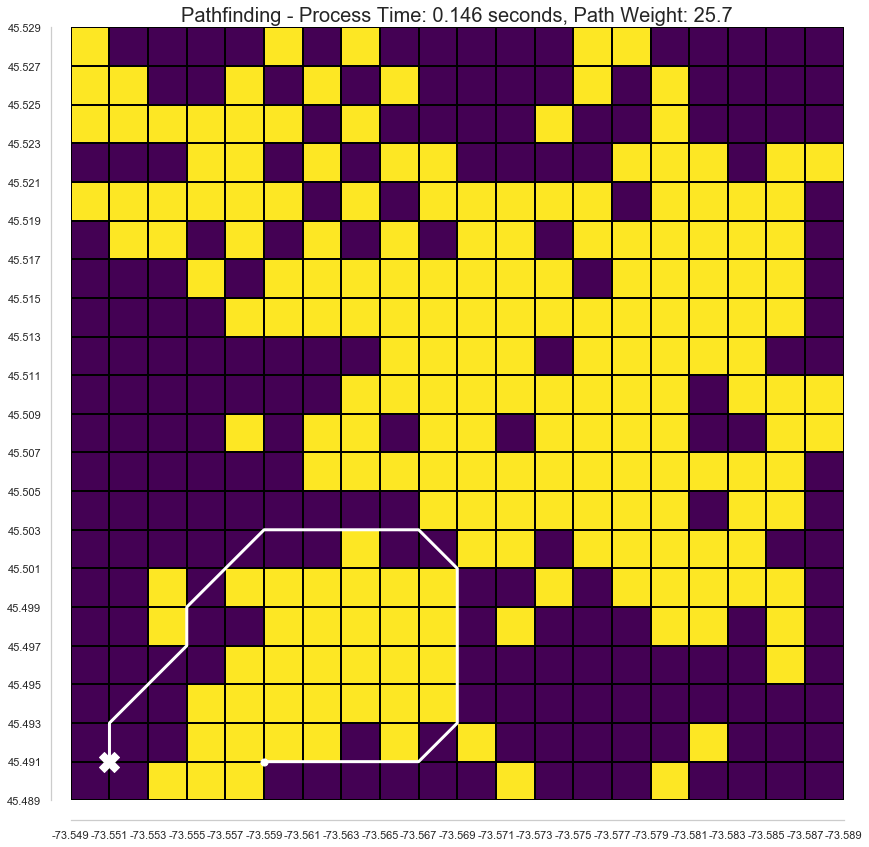

In [40]:
plot_path_50((5,1),(1,1))

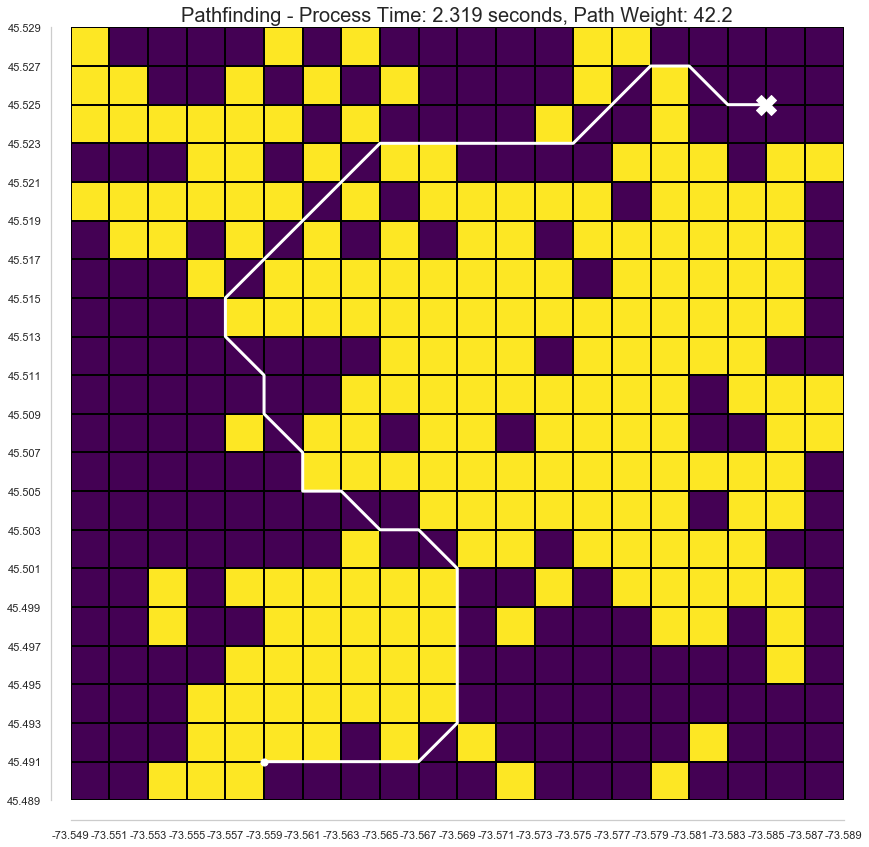

In [41]:
plot_path_50((5,1),(18,18))